# Polscope with phase reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftn, ifftn, fftshift, ifftshift

import pickle
import waveorder as wo

import time

%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Load data

In [2]:
# Load simulations

# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_17_illu_no_noise.pckl', 'rb')
# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_17_illu_theta_no_noise_Born.pckl', 'rb')
f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_no_noise.pckl', 'rb')
# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_3x_inc_no_noise_Born.pckl', 'rb')
# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_no_noise_Born.pckl','rb')
# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_inc_45_no_noise.pckl', 'rb')
# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_inc_45_no_noise_Born.pckl','rb')
# f = open('simulation_data_3D_Pol_phase_inc.pckl', 'rb')
# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_single_layer_no_noise.pckl', 'rb')
# f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_single_layer_thick_no_noise.pckl','rb')
I_meas, lambda_illu, n_media, ps, psz, NA_obj, NA_illu, Source_cont, z_defocus, chi = pickle.load(f)
f.close()


In [3]:
I_meas.shape

(5, 9, 200, 200, 100)

In [4]:
wo.image_stack_viewer(fftshift(Source_cont,axes=(1,2)), origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

### Stokes vector/Polarization reconstruction

In [5]:
_, _, N, M, L = I_meas.shape
cali        = False               
bg_option   = 'global'            
use_gpu = True
gpu_id = 3

setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media=n_media, cali=cali, phase_deconv='3D', inc_recon='3D', \
                                illu_mode='Arbitrary', Source = Source_cont, use_gpu=use_gpu, gpu_id=gpu_id)
S_image_recon = setup.Stokes_recon(I_meas)
S_image_tm = setup.Stokes_transform(S_image_recon)
S_image_tm[1] = S_image_tm[1] - np.mean(S_image_tm[1], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
S_image_tm[2] = S_image_tm[2] - np.mean(S_image_tm[2], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
Recon_para =setup.Polarization_recon(S_image_tm)

In [6]:
wo.parallel_5D_viewer(np.transpose(I_meas,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [7]:
wo.parallel_5D_viewer(np.transpose(S_image_recon,(4,1,0,2,3)), num_col=4, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [8]:
wo.parallel_5D_viewer(np.transpose(S_image_tm,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [9]:
wo.parallel_5D_viewer(np.transpose(Recon_para,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

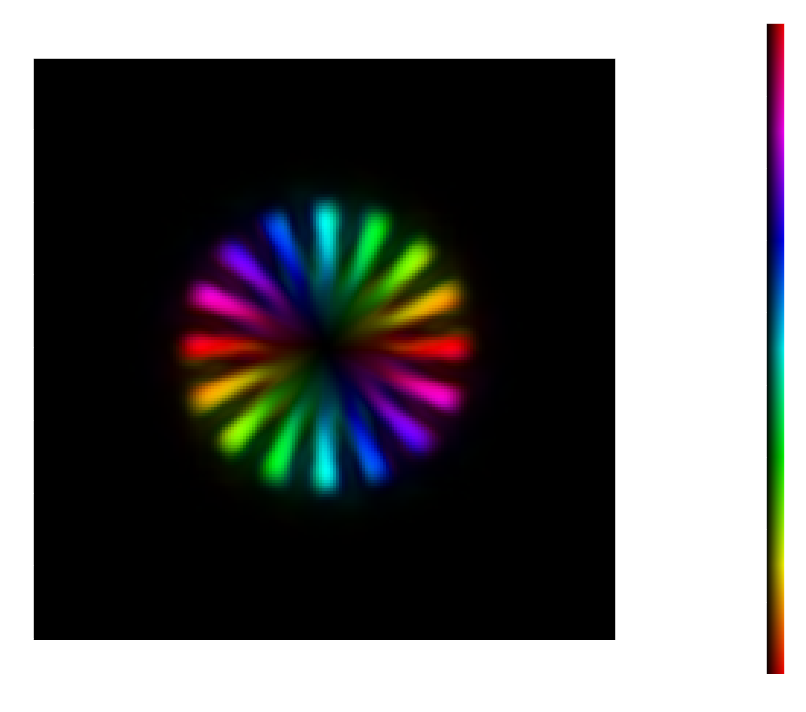

In [10]:
wo.plot_hsv([Recon_para[1,-1,:,:,25], Recon_para[0,-1,:,:,25]],max_val=1, origin='lower', size=10)

In [11]:
wo.hsv_stack_viewer([np.transpose(Recon_para[1,-1],(2,0,1)), np.transpose(Recon_para[0,-1],(2,0,1))], max_val=1, origin='lower', size=10)

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.hsv_stack_viewer.<locals>.interact_plot_hsv(stack_idx)>

In [12]:
wo.image_stack_viewer(np.transpose(Recon_para[0,-1]/np.pi/2*lambda_illu*1e3,(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

### 3D Phase reconstruction with $S_0$

In [13]:
phi_sample, mu_sample = setup.Phase_recon_3D(S_image_recon[0], method='Tikhonov', reg_re = 1e-5, reg_im = 1e-4, \
                                            rho = 1e-3, lambda_re = 1e-6, lambda_im = 1e-6, itr = 10, verbose=True)

In [14]:
wo.parallel_4D_viewer(np.transpose(np.stack([phi_sample, mu_sample]),(3,0,1,2)),origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [15]:
wo.parallel_4D_viewer(np.transpose(np.stack([phi_sample, mu_sample]),(1,0,3,2)),origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=199), Output()), _dom_classes=('widget-i…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [16]:
n_square = n_media**2 *(1 + (phi_sample-1j*mu_sample)/psz*4*np.pi/lambda_illu*n_media / (2*np.pi/lambda_illu)**2)
n_re = np.real(((np.abs(n_square) + np.real(n_square))/2)**(0.5))
n_im = np.real(((np.abs(n_square) - np.real(n_square))/2)**(0.5))

In [17]:
wo.parallel_4D_viewer(np.transpose(np.stack([n_re, n_im]),(3,0,1,2)),origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### 3D joint phase / orientation reconstruction w dyadic Greens function

In [18]:
for i in range(7):
    print(np.mean(np.abs(setup.inc_AHA_3D_vec[i,i])))

0.00018075816
0.00029827977
0.00039320003
0.0003931651
7.451995e-05
7.451993e-05
7.971996e-06


In [19]:
np.round(np.mean(np.abs(setup.H_dyadic_OTF),axis=(2,3,4,5)),5)

array([[6.3e-04, 7.3e-04, 2.1e-04, 2.1e-04, 2.3e-04, 2.3e-04, 8.0e-05],
       [2.3e-04, 2.3e-04, 6.4e-04, 7.2e-04, 2.3e-04, 2.3e-04, 8.0e-05],
       [2.3e-04, 2.3e-04, 7.2e-04, 6.4e-04, 2.3e-04, 2.3e-04, 8.0e-05]],
      dtype=float32)

In [32]:
reg_inc = np.array([1, 1, 1e1, 1e1, 1e1, 1e1, 1e1])*1
reg_ret_pr = 1e-1

S_image_tm_0 = (S_image_recon[0] - np.mean(S_image_recon[0], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis])/\
                np.mean(S_image_recon[0], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]

S_image_tm_1 = (S_image_recon[1] - np.mean(S_image_recon[1], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis])/\
                np.mean(S_image_recon[0], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]

S_image_tm_2 = (S_image_recon[2] - np.mean(S_image_recon[2], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis])/\
                np.mean(S_image_recon[0], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]

del_f_sol, retardance_pr, azimuth, theta = setup.Inclination_recon_3D_vec(np.stack([S_image_tm_0, S_image_tm_1, S_image_tm_2]), \
                                                                          reg_inc=reg_inc, reg_ret_pr = reg_ret_pr)

Finished preprocess, elapsed time: 16.47
Finished reconstruction, elapsed time: 36.59


In [33]:
wo.parallel_4D_viewer(np.transpose(del_f_sol,(3,0,1,2)), num_col=4, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [34]:
wo.parallel_4D_viewer(np.transpose(np.stack([-del_f_sol[0]/(4*np.pi/lambda_illu*n_media)*psz, \
                                             retardance_pr/(2*np.pi/lambda_illu*n_media)*psz/2/np.pi*lambda_illu*1e3, \
                                             azimuth, theta]),(3,0,1,2)), num_col=4, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

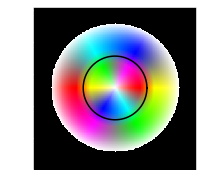

In [35]:

orientation_3D_image = np.transpose(np.array([azimuth/2/np.pi, theta, np.clip(retardance_pr/np.max(retardance_pr),0,1)]),(3,1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)


wo.rgb_stack_viewer(orientation_3D_image_RGB, size=10, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

interactive(children=(IntSlider(value=0, description='stack_idx', max=199), Output()), _dom_classes=('widget-i…

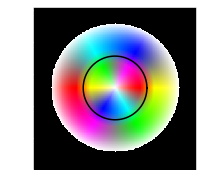

In [36]:
wo.rgb_stack_viewer(np.transpose(orientation_3D_image_RGB,(1,0,2,3)), size=10, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

Text(0.5, 1.0, 'recon')

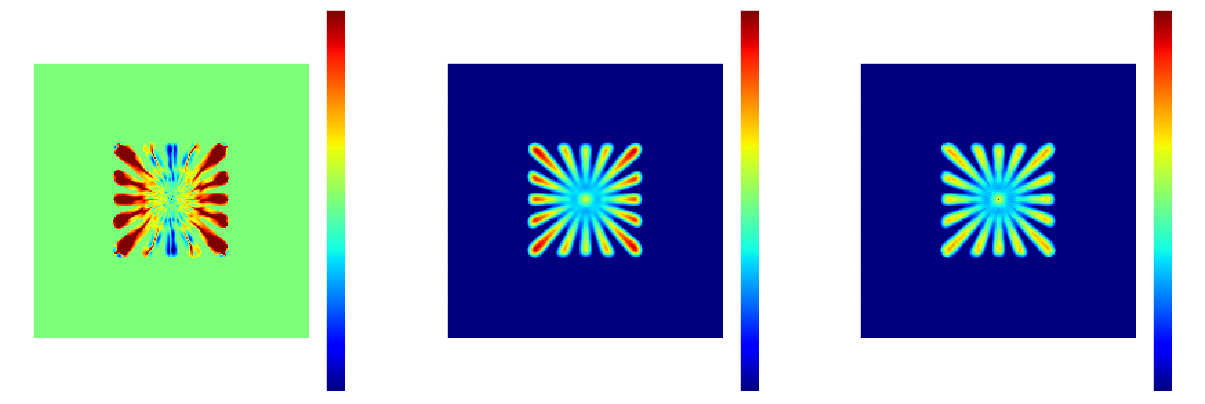

In [37]:
target, _, xx = wo.genStarTarget(N,M)
xx = xx/np.max(xx)
inc_angle = (np.abs(np.pi/2 * xx) + np.pi/2)
# azimuth = np.abs(azimuth)

target = np.pad(target[:,:,np.newaxis], ((0,0), (0,0), (50,49)), mode='constant')
# azimuth = np.pad(azimuth[:,:,np.newaxis], ((0,0), (0,0), (50,49)), mode='constant')
inc_angle = np.pad(inc_angle[:,:,np.newaxis], ((0,0), (0,0), (50,49)), mode='constant')

mask = target.copy()
mask[mask<0.2] = 0
# mask = np.ones_like(target)

fig, ax = plt.subplots(1,3,figsize=(21,7))
ax1 = ax[0].imshow((mask*(inc_angle-(np.abs(theta-np.pi/2)+np.pi/2)))[:,:,50]/np.pi*180, cmap='jet', origin='lower', vmin=-10, vmax=10)
plt.colorbar(ax1,ax=ax[0])
ax2 = ax[1].imshow((mask*inc_angle)[:,:,50]/np.pi*180, cmap='jet', origin='lower', vmin=0, vmax=130)
plt.colorbar(ax2,ax=ax[1])
ax3 = ax[2].imshow((mask*(np.abs(theta-np.pi/2)+np.pi/2))[:,:,50]/np.pi*180, cmap='jet', origin='lower',vmin=0, vmax=130)
plt.colorbar(ax3,ax=ax[2])


ax[0].set_title('ground truth - recon')
ax[1].set_title('ground truth')
ax[2].set_title('recon')



Text(0.5, 1.0, 'recon')

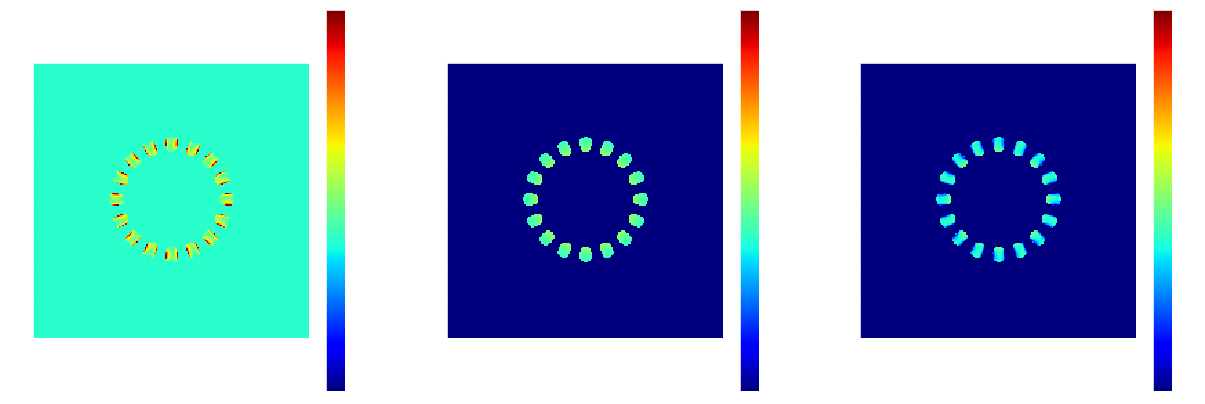

In [38]:
blur_size = 1*ps
# target, azimuth_t, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size, inc_upper_bound=np.pi/4, inc_range=np.pi/64)
target, azimuth_t, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size)
# inc_angle = (inc_angle-np.pi/2)*3+np.pi/2

mask = target.copy()
mask[mask>0.2] = 1
mask[mask<=0.2] = 0
# mask = np.ones_like(target)

fig, ax = plt.subplots(1,3,figsize=(21,7))
ax1 = ax[0].imshow((mask*(inc_angle-(np.abs(theta-np.pi/2)+np.pi/2)))[:,:,25]/np.pi*180, cmap='jet', origin='lower', vmin=-10, vmax=15)
plt.colorbar(ax1,ax=ax[0])
ax2 = ax[1].imshow((mask*inc_angle)[:,:,25]/np.pi*180, cmap='jet', origin='lower', vmin=90, vmax=135)
plt.colorbar(ax2,ax=ax[1])
ax3 = ax[2].imshow((mask*(np.abs(theta-np.pi/2)+np.pi/2))[:,:,25]/np.pi*180, cmap='jet', origin='lower',vmin=90, vmax=135)
plt.colorbar(ax3,ax=ax[2])


ax[0].set_title('ground truth - recon')
ax[1].set_title('ground truth')
ax[2].set_title('recon')


In [39]:
import cupy as cp
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [41]:
(np.sum((mask*(inc_angle-(np.abs(theta-np.pi/2)+np.pi/2)))[:,:,25]**2)/np.sum(mask[:,:,25]))**0.5*180/np.pi

6.055724713054473